# Table of Contents
 <p><div class="lev1 toc-item"><a href="#OSMI-Health-Survey-2016:-Inference" data-toc-modified-id="OSMI-Health-Survey-2016:-Inference-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>OSMI Health Survey 2016: Inference</a></div><div class="lev1 toc-item"><a href="#Recap" data-toc-modified-id="Recap-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Recap</a></div><div class="lev1 toc-item"><a href="#Fit-and-Diagnostics" data-toc-modified-id="Fit-and-Diagnostics-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Fit and Diagnostics</a></div><div class="lev1 toc-item"><a href="#Interpretation-(If-the-model-is-well-specified)" data-toc-modified-id="Interpretation-(If-the-model-is-well-specified)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Interpretation (If the model is well-specified)</a></div><div class="lev1 toc-item"><a href="#Discussion,-Limitations,-Further-Work" data-toc-modified-id="Discussion,-Limitations,-Further-Work-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Discussion, Limitations, Further Work</a></div>

# OSMI Health Survey 2016: Inference

_By [Michael Rosenberg](mailto:mmrosenb@andrew.cmu.edu)._

_**Description**: Contains my inference related to the [OSMI Mental Health In Tech Survey 2016](https://osmihelp.org/research/). This notebook is written in `R`._

In [72]:
#imports
#constants
sigLev = 3
lineWidth = 3

# Recap

As discussed in my [model selection procedure](modelSelection.ipynb), I ended up choosing a model that represents a logistic regression, i.e.

$$P(diagnosedWithMHD_i | X) = \frac{1}{1+e^{-\hat{r}(X)}},$$

where $\hat{r}(X)$ is the fitted regression function that contains the following variables:

* ```age```: covers the age of a respondent.

* ```roleType```: engages the role type of a respondent at work, which can either be technical, non-technical, or both (i.e. hybrid roles).

* ```isUSA```: asks if the individual works in the USA or not (1 if they do, 0 if they don't).

* ```gender```: the gender that the individual identifies with. For the sake of simplification, we say that an individual is give "F" if they identify as a female, "M" if they identify as a male, and "O" if they identify as another gender not along the binary. We had to do this pooling for "O" since there were unfortunately only a small number of observations that did not identify along the gender binary.

* The interaction term between ```age``` and ```gender```.

Let us fit this on our test set and perform some set of inference.

# Fit and Diagnostics

In [18]:
#load in formula
formulaFilename = "../models/finalLogisticRegressionFormula.txt"
#get rid of newline character at the end, so -1
formula = readChar(formulaFilename,file.info(formulaFilename)$size - 1)
print(formula)

[1] "diagnosedWithMHD ~ age+factor(gender)+factor(roleType)+factor(isUSA)+age:factor(gender)"


In [19]:
#load in data
inferenceSet = read.csv("../data/processed/test.csv")
#then fit model
finalMod.logr = glm(formula,data = inferenceSet,family = "binomial")

Let's first see how well our model is fitting the inference set.

In [20]:
inferenceSet$prediction = predict(finalMod.logr,type = "response")
#make decision rule
decRule = .5
inferenceSet$prediction = ifelse(inferenceSet$prediction > decRule,1,0)
#make comparision
correctFrame = inferenceSet[which(inferenceSet$diagnosedWithMHD ==
                                  inferenceSet$prediction),]
#get proportion accurate
propAccurate = dim(correctFrame)[1] / dim(inferenceSet)[1]
print(paste("The proportion accurate on the inference set is",signif(
                                                    propAccurate,sigLev)))

[1] "The proportion accurate on the inference set is 0.604"


This is still not an amazing fit, but it's performing about on par as the fits in our previous discussion. This may suggest that we simply aren't fitting the data extremely well, and that it might be essential to go back into the survey and find other variables that would be strong predictors of this outcome. We could also be dealing with the question of simply not asking all the questions we need to get a full picture of someone's mental health (e.g. how are there eating habits, what are there hours like at work, what is their social life like, etc). We may be able to get some more meaningful statements about factors contributing to mental health in tech if we asked some of these questions.

Let's see by the confusion matrix what kinds of places are we making mistakes.

In [21]:
confusionMat = matrix(0,nrow = 2,ncol = 2)
for (i in 1:2){
    for (j in 1:2){
        #get level associated
        confusionMat[i,j] = length(which(inferenceSet$predictions == i - 1 &
                                inferenceSet$diagnosedWithMHD == j - 1))
    }
}
#name columns
rownames(confusionMat) = c("Predict 0","Predict 1")
colnames(confusionMat) = c("Actual 0","Actual 1")
confusionMat

,Actual 0,Actual 1
Predict 0,233,161
Predict 1,122,198


_Table 1: Our confusion matrix for our model._

We see that we have a false negative rate of around $\frac{161}{161 + 198} \cdot 100\% \approx 44.85\%$, along with a false positive rate of about $\frac{122}{122+233} \cdot 100\% \approx 34.37\%.$ Thus, we have a slightly bigger false negative problem than a false positive problem. This may be useful to note for if we wanted to do future tuning.

# Interpretation (If the model is well-specified)

If our model is well-specified, we can interpret our model through simply the coefficients currently present, and their statistical significance. Obviously, some of these run under the assumptions that the model is well-specified; we will use some techniques later as robustness checks on the significance of these variables.

In [22]:
summary(finalMod.logr)


Call:
glm(formula = formula, family = "binomial", data = inferenceSet)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0102  -1.1208   0.5626   1.1507   1.7344  

Coefficients:
                               Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -0.070454   0.652334  -0.108 0.913994    
age                            0.009834   0.017589   0.559 0.576084    
factor(gender)M               -1.145899   0.740104  -1.548 0.121552    
factor(gender)O                0.546165   2.129787   0.256 0.797610    
factor(roleType)non-technical -0.020592   0.213527  -0.096 0.923174    
factor(roleType)technical     -0.102976   0.189235  -0.544 0.586324    
factor(isUSA)1                 0.542171   0.158222   3.427 0.000611 ***
age:factor(gender)M            0.012324   0.020899   0.590 0.555381    
age:factor(gender)O            0.013099   0.067543   0.194 0.846224    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion

_Table 2: Summary of our fitted model._

Unfortunately, we see statistical significance in only one of our variables: $isUSA_i$. That being said, there are some very powerful effect sizes estimated in this model. By the coefficient of $isUSA_i$, We see that if the respondent's work occurs in the United States, that predicts on average that a respondent is $\exp(.542171) \approx 1.7$ times as likely to be diagnosed with a mental health disorder than if the respondent worked outside the United States. There could be two possible explanations underlying this component: either that

1. The United States could have a stress culture in technology that pushes more individuals to a point of having a mental health disorder.

2. The United States has a framework for handling mental health that diagnoses more people on average than other countries.

I personally find the second explanation to be a stronger reasoning behind this issue. When we compare how developed countries handle mental health when compared to emerging markets, it is apparent that the mental health landscape of the United States is a relatively strong one.

We also see a coefficient on $isTechnical_i$ of  $-.103$, which would predict an odds ratio effect of $\exp(-.103) \approx .902.$ This would suggest that someone working in a technical role is predicted to on average be $\approx 10\%$ less likely to be diagnosed with a mental health disorder than someone who takes on both technical and non-technical roles. This may suggest that individuals who take a jack-of-all-trades approach in the tech industry may be overburdened, to a point where they are much more likely to face pressures on their mental health than those who solely act in technical roles.

Let us interpret the gender effects using a set of point predictions. In particular, let us look at the average age of those who identify as female in the inference set.

In [23]:
femaleFrame = inferenceSet[which(inferenceSet$gender == "F"),]
avgFemaleAge = mean(femaleFrame$age)
print(paste("The average age of those who identify as female",
            "in the inference set is",round(avgFemaleAge)))

[1] "The average age of those who identify as female in the inference set is 35"


Let us get some predictions on diagnosis rate of those who identify as female in the US at this age in technical roles.

In [39]:
ageLev = 35
predictionFrame = data.frame(age = ageLev,
                            gender = c("F","M","O"),
                            isUSA = 1,
                            roleType = "technical")
#make predictions
givenPredictions = predict(finalMod.logr,newdata = predictionFrame,
                           type = "response",se.fit = TRUE)
#then store some information
predictionFrame$prediction = givenPredictions$fit
#confidence interval around point prediction
critVal = 1.96
predictionFrame$lwr = (predictionFrame$prediction
                            - critVal * givenPredictions$se.fit)
predictionFrame$upr = (predictionFrame$prediction
                            + critVal * givenPredictions$se.fit)
predictionFrame

age,gender,isUSA,roleType,prediction,lwr,upr
35,F,1,technical,0.6710508,0.5894421,0.7526595
35,M,1,technical,0.4995991,0.4303545,0.5688437
35,O,1,technical,0.8478170,0.6795415,1.0160925


_Table 3: Point predictions for particular levels along with $95\%$ confidence intervals for said predictions._

We see that for an American who identifies as female of average age in a solely technical role, we predict on average a diagnosis rate of $67.1\%.$ For an american male of the same age in a technical role, we predict on average a diagnosis rate close to $50\%$. Interestingly, This suggests that individuals who identify as female in solely technical roles are probably much more likely to face a higher rate of diagnosis than individuals who identify as male. In particular, it looks like males are much more of a toss-up for diagnosis at this age than females. It is also important to note that the predicted diagnosis rate for those of other genders in the same demographics is disturbingly high.

Let's take a look at the rate of a recent college graduate in the US (i.e. age $23$).

In [40]:
ageLev = 23
predictionFrame = data.frame(age = ageLev,
                            gender = c("F","M","O"),
                            isUSA = 1,
                            roleType = "technical")
#make predictions
givenPredictions = predict(finalMod.logr,newdata = predictionFrame,
                           type = "response",se.fit = TRUE)
#then store some information
predictionFrame$prediction = givenPredictions$fit
#confidence interval around point prediction
critVal = 1.96
predictionFrame$lwr = (predictionFrame$prediction
                            - critVal * givenPredictions$se.fit)
predictionFrame$upr = (predictionFrame$prediction
                            + critVal * givenPredictions$se.fit)
predictionFrame

age,gender,isUSA,roleType,prediction,lwr,upr
23,F,1,technical,0.6444955,0.5234890,0.7655019
23,M,1,technical,0.4335190,0.3432832,0.5237549
23,O,1,technical,0.8088227,0.5851047,1.0325406


_Table 4: Predictions for individuals right out of college._

In [52]:
#get slopes for gender
coefVec = coefficients(finalMod.logr)
femaleSlope = coefVec["age"]
maleSlope = femaleSlope + coefVec["age:factor(gender)M"]
otherSlope = femaleSlope + coefVec["age:factor(gender)O"]
#get base values
baseFrame = data.frame(age = 0,isUSA = 1,roleType = "technical",
                       gender = c("F","M","O"))
baseLink = predict(finalMod.logr,newdata = baseFrame,type = "link")
names(baseLink) = c("F","M","O")
#make a function for our predictions
makeResponsePrediction <- function(ageSlope,baseLink,age){
    #helper that makes response prediction solely a function of age
    link = baseLink + ageSlope * age
    response = 1 / (1 + exp(-link))
    return(response)
}

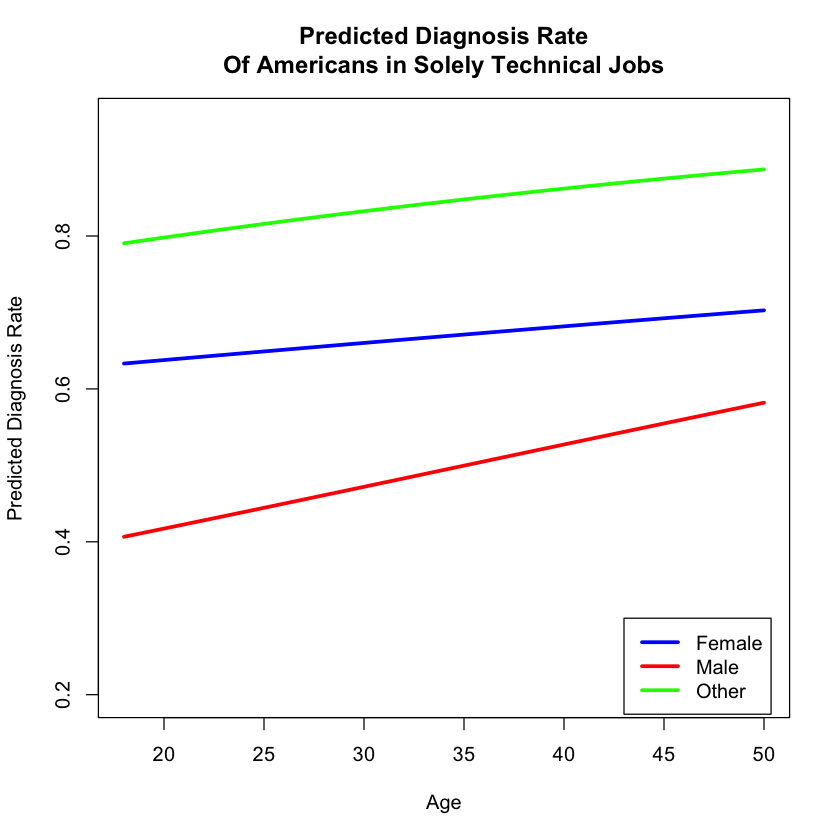

In [91]:
#then plot partial response graphs
ageVec = 18:50 #consider 18-year-olds to 55-year-olds
femaleResponse = makeResponsePrediction(femaleSlope,baseLink["F"],ageVec)
maleResponse = makeResponsePrediction(maleSlope,baseLink["M"],ageVec)
otherResponse = makeResponsePrediction(otherSlope,baseLink["O"],ageVec)
plot(c(18,50),c(.2,.95),type = "n",xlab = "Age",
     ylab = "Predicted Diagnosis Rate",
     main = "Predicted Diagnosis Rate\nOf Americans in Solely Technical Jobs")
lines(ageVec,femaleResponse,col = "blue",lwd = lineWidth)
lines(ageVec,maleResponse,col = "red",lwd = lineWidth)
lines(ageVec,otherResponse,col = "green",lwd = lineWidth)
legend(43,.3,c("Female","Male","Other"),lty = c(1,1,1),
       lwd = lineWidth,col = c("blue","red","green"))

_Figure 1: Partial Response Graph on Age for those who identify as female (blue), those who identify as male (red), and those who identify as other genders (green)._

In general, we see higher predicted diagnosis rates for persons who identify as non-male genders, But the slope for those who identify as male is interesting. We see a much faster growing rate for men as they age compared to women as they age. That being said, given that the mean age of our inference set is about 34 , it is very possible that we are doing major extrapolation when we are considering ages above $45$. Let us compare this to the age distribution.

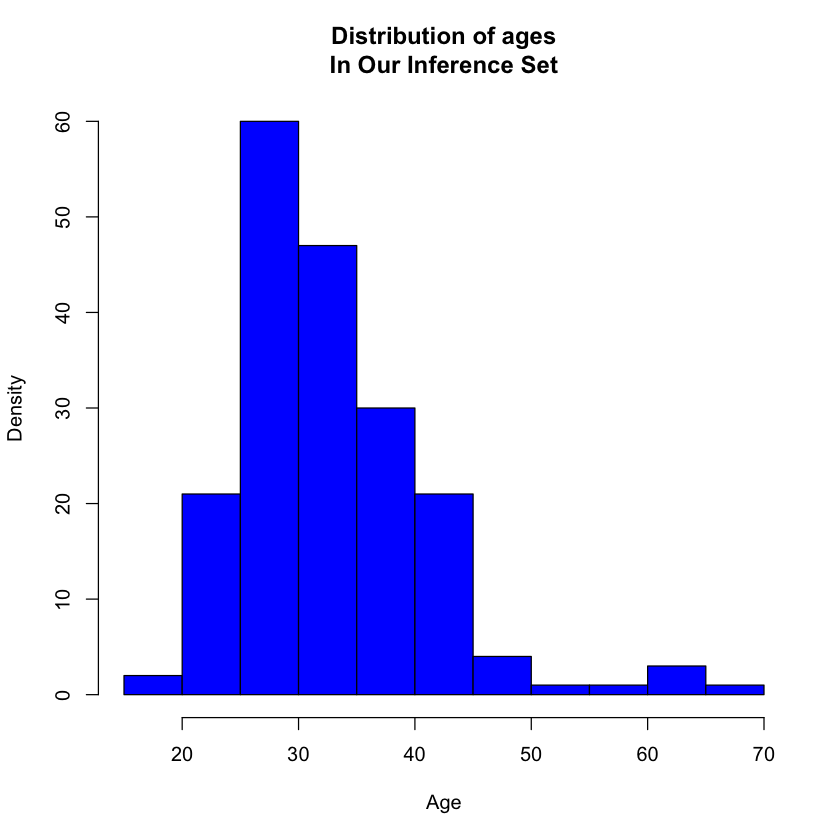

In [94]:
consideredPersonsFrame = inferenceSet[which(inferenceSet$isUSA == 1 &
                                        inferenceSet$roleType == "technical"),]
hist(consideredPersonsFrame$age,col = "Blue",xlab = "Age",
     ylab = "Density",main = "Distribution of ages\nIn Our Inference Set")

_Figure 2: Distribution of Ages._

# Discussion, Limitations, Further Work

There are a couple of key insights we can glean from our analysis:

* Our model is currently not extremely accurate (currently at $60.5\%$ on the inference set), and so we should probably take most of our results with a general grain of salt.

* We see that the work occuring in the United States provides a large predicted increase in the likelihood of a mental health diagnosis. This has the potential to either be a narrative about the United States having a significantly larger stress culture in technology than other environments, or the fact that the US has generally a larger diagnosis rate due to a potentially more fleshed-out mental healthcare system than other countries. Figuring out which of these two narratives is accurate would require further studying beyond this dataset.

* Generally, individuals who take on either hybrid or solely non-technical roles are predicted to on average have higher diagnosis rates than individuals who do solely technical work. This may suggest that the treatment of workers in non-technical roles tends to be poorer than technical workers in the tech industry, although this would require analyzing some parts of the survey that pertain to the hours and working conditions of technical and non-technical workers.

* We see that American individuals that identify as non-male genders in technical work are predicted to have much higher diagnosis rates than American technical workers that identify as male. While this effect is not found to be currently statistically significant, it is important to recognize that this gender effect could have many meaningful narratives to discuss. It is possible that there are genuine stressors in the tech industry that create an environment that causes damage to the mental health of persons of non-male genders. That being said, it is also possible that individuals that identify as non-male genders admit to having mental health disorders more easily than individuals that identify as male. This narrative would suggest that this predicted higher rate may be independent of the stressors of work. Both narratives would need to be further studied using information outside of what is available on this survey.

* We see that for American technical workers, the predicted diagnosis rate for those who identify as male increases faster with age than the predicted diagnosis rate for those who identify as non-male. This suggests that as the years go on, we predict that the male diagnosis rate will eventually converge with the female diagnosis rate. That being said, given that the age of most of these technical workers lie around $[20,45]$ range (see Figure 2), It is very possible that this is a slight extrapolation from what we consider.

Some limitations:

* Our model is not a strong fit for the inference set, and thus it is very likely that we are not entirely capturing the data-generating process with this model.

* Since our model is not a strong fit, it is likely not well-specified, which would suggest that our $p$-values are not an accurate portrayal of the significance of our coefficients.

* This survey has a selection bias issue [in the way that is collected](https://data.world/kittybot/osmi-mental-health-tech-2016/discuss/lets-get-started-digging-through-this-data/7660). In particular, it was distributed through twitter and conferences, and was primarily volunteer-based. This suggests that our sample is likely self-selected to have individuals who are especially interested in mental health. This selection bias makes our results hard to generalize to the industry as a whole.

* We have a very limited number of individuals who identify not on the gender binary. This group is especially interesting in our dataset because they seem to present very high rates of diagnosis of mental health disorders. It is very possible that the difficulties of working as a non-binary individual in a society that pressures individuals to fit the binary can cause issues for the mental health of non-binary individuals. However, because we have such a small sample, it is difficult for us to make any strong statements about this group due to the high variability of our results pertaining to this group.

Some further work to consider:

* Much of the reset of the survey deals with questions related to how workplaces, companies, and the industry as a whole deal with mental health. If we perform some kind of cluster analysis on these responses, we may be able to get a set of narratives on how the industry is performing as a whole to deal with mental health on the job.

* Because our model is not extremely accurate, it would be useful to consider measurements of workplace stress, pressure, and culture in a further survey. These may help to inform our variable of medical diagnosis.

* Being medically diagnosed with a mental health disorder is not the only possible target variable to consider. We have two measurements to consider otherwise: whether or not someone thinks they currently have a mental health diagnosis, and whether or not someone think they had a mental health diagnosis in the past. Both of these could present meaningful analyses and statements if we measured the effects of demographic and employment variables on these targets.

* Since it is not clear if our logistic regression is well-specified, interpretting the $p$-values is rather spurious, and so I spent most of this analysis considering effect sizes rather than $p$-values. That being said, we may be able to measure significance without a well-specified model by using a set of bootstrap simulations with resampling of cases over our model coefficients.

* Since this survey also was taken in 2014, it may be useful to do a yearly analysis and see if our results change over time. Since this is a survey that is volunteer-based, we can't do a formal cohort analysis. However, it may be interesting to see if the pulse on the industry's mental health has changed between these two time points.